In [125]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
import numpy as np

from mads_hackathon import datasets, metrics
import mltrainer
import tomllib

In [126]:

configfile = Path("config.toml")
with configfile.open("rb") as f:
    tomlconfig = tomllib.load(f)

assert tomlconfig["dev"] != "dev", ValueError("Please set dev in config.toml to your own name")
assert tomlconfig["port"] != "none", ValueError("Please set port in config.toml to your own port")
uri = tomlconfig["mlflow_uri"] + ":" + tomlconfig["port"]
dev = tomlconfig["dev"]
print(f"Using {uri} as mlfow uri")
print(f"Using {dev} as dev name")

Using http://145.38.195.42:5002 as mlfow uri
Using dev-Sven as dev name


In [127]:
import torch
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
elif torch.cuda.is_available():
    device = "cuda:0"
    print("using cuda")
else:
    device = "cpu"
    print("using cpu")

using cuda


In [128]:
datadir = Path('../hackathon-data/')
trainfile = (datadir / "heart_big_train.parq").resolve()
validfile = (datadir / "heart_big_valid.parq").resolve()
trainfile.exists(), validfile.exists()

(True, True)

In [129]:
import torch

train_df = pd.read_parquet(trainfile)
train_percentages = train_df.target.value_counts(normalize=True).sort_index() * 100
weights1 = torch.tensor((100.0 / train_percentages).to_numpy()).float().to(device)
weights2 = torch.tensor((1.0 / train_percentages).to_numpy()).float().to(device)
weights1, weights2

(tensor([  1.2081,  39.3855,  15.1268, 136.5897,  13.6144], device='cuda:0'),
 tensor([0.0121, 0.3939, 0.1513, 1.3659, 0.1361], device='cuda:0'))

Load the data

In [130]:
traindataset = datasets.HeartDataset1D(trainfile, target="target")
validdataset = datasets.HeartDataset1D(validfile, target="target")
traindataset.to(device), validdataset.to(device)

# moving to mps device crashes the jypyter kernel, I wasnt able to fix that...

(None, None)

Visualise it as 1D data

torch.Size([192, 1]) tensor(0, device='cuda:0')


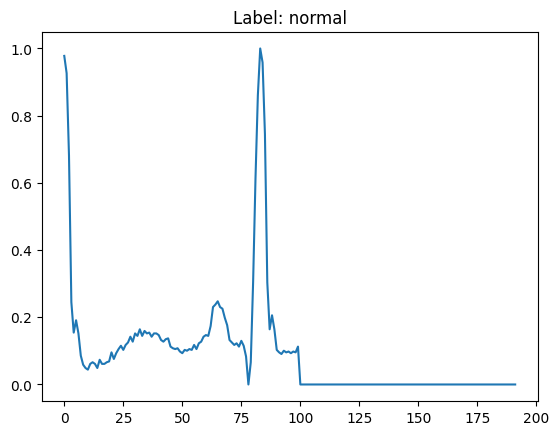

In [131]:
x, y = traindataset[0]
viz = x.squeeze().cpu().numpy()
sns.lineplot(x=range(len(viz)), y=viz)
title = 'normal' if y == 0 else 'abnormal'
plt.title(f"Label: {title}");
print(x.shape, y)

In [132]:
from mads_hackathon.models import TransformerConfig as Config

config = Config(
    batchsize=128,
    dropout=0.1,
    input_channels=1,
    hidden=64,
    kernel_size=3,
    stride=1,
    num_heads=2,
    num_blocks=2,
    num_classes=5,
)

Set up the streamer

In [133]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=config.batchsize)
validstreamer = BaseDatastreamer(validdataset, preprocessor = BasePreprocessor(), batchsize=config.batchsize)
len(trainstreamer), len(validstreamer)

(684, 85)

Note, the layers have different assumptions about the data structure:
- streamer:         (batch, seq_len, channels)
- conv1d:           (batch, channels, seq_len)
- pos_encoding:     (batch, seq_len, channels)
- gru (batchfirst): (batch, seq_len, channels)
- attention:        (batch, seq_len, channels)

As you can see, its just the conv1d layer that expects channels as the second dimension. Using a conv1d layer you
will need to transpose the dimensions, I will show how to do that in the Transformer `forward` method.

Again, the strategy of creating a block helps us stack the architecture more easily.

In [134]:
from mads_hackathon.models import Transformer
model = Transformer(config)

In [135]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([128, 192, 1]), torch.Size([128]))

In [136]:
from torchinfo import summary

summary(model, input_size=x.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Transformer                              [128, 5]                  --
├─Conv1d: 1-1                            [128, 64, 192]            256
├─PositionalEncoding: 1-2                [128, 192, 64]            --
│    └─Dropout: 2-1                      [128, 192, 64]            --
├─ModuleList: 1-3                        --                        --
│    └─TransformerBlock: 2-2             [128, 192, 64]            --
│    │    └─MultiheadAttention: 3-1      [128, 192, 64]            16,640
│    │    └─LayerNorm: 3-2               [128, 192, 64]            128
│    │    └─Sequential: 3-3              [128, 192, 64]            8,320
│    │    └─LayerNorm: 3-4               [128, 192, 64]            128
│    └─TransformerBlock: 2-3             [128, 192, 64]            --
│    │    └─MultiheadAttention: 3-5      [128, 192, 64]            16,640
│    │    └─LayerNorm: 3-6               [128, 192, 64]            128


In [137]:
model.to(device)
yhat = model(x)
yhat.shape

torch.Size([128, 5])

In [138]:
from mads_hackathon.metrics import caluclate_cfm
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [139]:
import mlflow
#mlflow.set_tracking_uri(uri)
#mlflow.set_experiment("Transformer")

2024-11-25 14:09:44.234 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20241125-140944
  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 684/684 [00:07<00:00, 92.19it/s]
2024-11-25 14:09:52.439 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.3332 test 0.1927 metric ['0.9505', '0.9505', '0.7269', '0.9505', '0.7112']
100%|██████████| 684/684 [00:07<00:00, 92.46it/s]
2024-11-25 14:10:00.615 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.1798 test 0.1597 metric ['0.9559', '0.9559', '0.7680', '0.9559', '0.7569']
100%|██████████| 684/684 [00:07<00:00, 91.65it/s]
2024-11-25 14:10:08.876 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1522 test 0.1389 metric ['0.9629', '0.9629', '0.7921', '0.9629', '0.7951']
100%|██████████| 684/684 [00:07<00:00, 90.96it/s]
2024-11-25 14:10:17.178 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1384 test 0.1292 metric ['0.9655', '0.9655', '0.8237', '0.9655', '0.8255']
100%|██████████| 684/684 [00:07<00:00, 91.29it/s]
2024-11-25 14:10:25.469 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 0.1286 test 0.1211 metric ['0.96

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

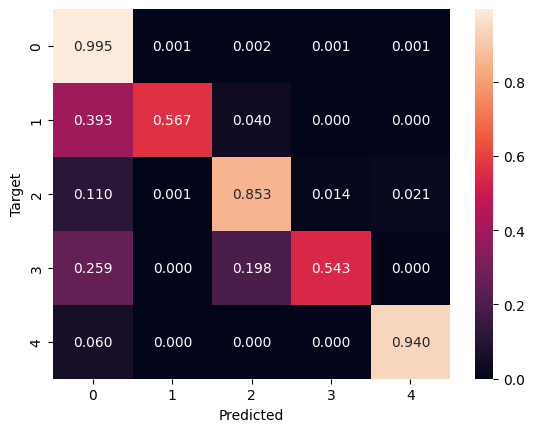

In [140]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
from dataclasses import asdict

loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer),
        valid_steps=len(validstreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart1D")
    mlflow.set_tag("dev", dev)
    mlflow.log_params(asdict(config))
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=validstreamer.stream(),
        scheduler=None,
        )
    trainer.loop()
    cfm = caluclate_cfm(model, validstreamer)
    for i, tp in enumerate(np.diag(cfm)):
        mlflow.log_metric(f"TP_{i}", tp)
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

2024-11-25 14:10:26.069 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20241125-141026
  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 684/684 [00:07<00:00, 91.22it/s]
2024-11-25 14:10:34.346 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.3728 test 0.3516 metric ['0.8354', '0.8354', '0.6295', '0.8354', '0.8723']
100%|██████████| 684/684 [00:07<00:00, 92.78it/s]
2024-11-25 14:10:42.490 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.3472 test 0.3256 metric ['0.8776', '0.8776', '0.6617', '0.8776', '0.8783']
100%|██████████| 684/684 [00:07<00:00, 92.73it/s]
2024-11-25 14:10:50.634 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.3314 test 0.3179 metric ['0.9250', '0.9250', '0.7389', '0.9250', '0.8861']
100%|██████████| 684/684 [00:07<00:00, 91.25it/s]
2024-11-25 14:10:58.923 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.3081 test 0.3452 metric ['0.8791', '0.8791', '0.6622', '0.8791', '0.8859']
100%|██████████| 684/684 [00:07<00:00, 91.20it/s]
2024-11-25 14:11:07.210 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 0.3154 test 0.3075 metric ['0.80

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

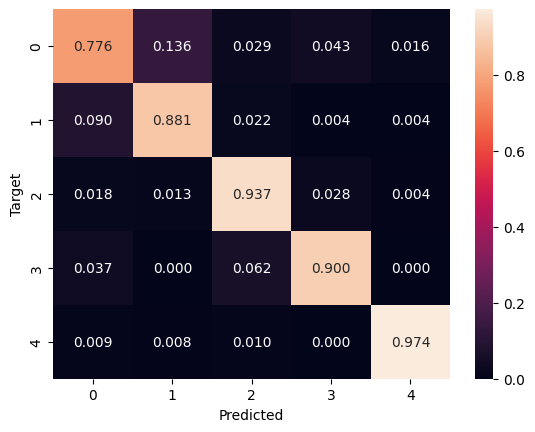

In [141]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
from dataclasses import asdict

loss_fn = torch.nn.CrossEntropyLoss(weight=weights2)

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer),
        valid_steps=len(validstreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart1D")
    mlflow.set_tag("dev", dev)
    mlflow.log_params(asdict(config))
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=validstreamer.stream(),
        scheduler=None,
        )
    trainer.loop()
    cfm = caluclate_cfm(model, validstreamer)
    for i, tp in enumerate(np.diag(cfm)):
        mlflow.log_metric(f"TP_{i}", tp)
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

2024-11-25 14:11:07.801 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20241125-141107
100%|██████████| 684/684 [00:07<00:00, 90.44it/s]
2024-11-25 14:11:16.156 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.2987 test 0.2948 metric ['0.9224', '0.9224', '0.7149', '0.9224', '0.8973']
100%|██████████| 684/684 [00:07<00:00, 90.70it/s]
2024-11-25 14:11:24.472 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2913 test 0.2840 metric ['0.9003', '0.9003', '0.6874', '0.9003', '0.8936']
100%|██████████| 684/684 [00:07<00:00, 90.51it/s]
2024-11-25 14:11:32.818 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2804 test 0.3002 metric ['0.8856', '0.8856', '0.6701', '0.8856', '0.8918']
100%|██████████| 684/684 [00:07<00:00, 92.16it/s]
2024-11-25 14:11:41.018 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.2781 test 0.3022 metric ['0.8834', '0.8834', '0.6659', '0.8834', '0.8956']
100%|██████████| 684/684 [00:07<00:00, 92.78it

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

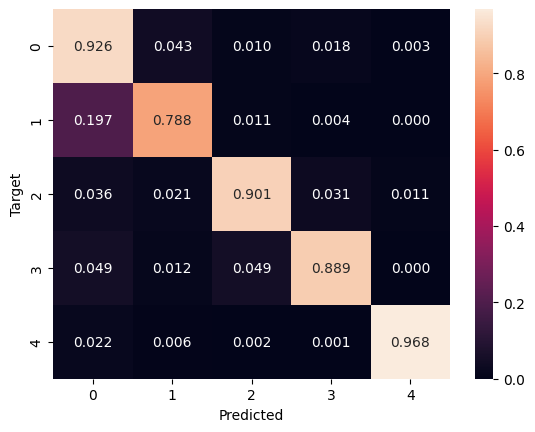

In [142]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
from dataclasses import asdict

loss_fn = torch.nn.CrossEntropyLoss(weight=weights1)

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer),
        valid_steps=len(validstreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart1D")
    mlflow.set_tag("dev", dev)
    mlflow.log_params(asdict(config))
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=validstreamer.stream(),
        scheduler=None,
        )
    trainer.loop()
    cfm = caluclate_cfm(model, validstreamer)
    for i, tp in enumerate(np.diag(cfm)):
        mlflow.log_metric(f"TP_{i}", tp)
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

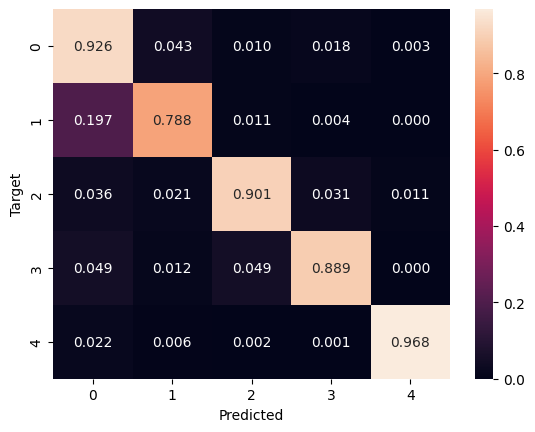

In [143]:
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")